In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### The purpose of this notebook is to explore using dgl libaray for GAT implementation

In [2]:
#To use double-precision numbers: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random, vmap#, nn
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors,stack_feature_tensors
from patch_gnn.layers import concatenate_node_features,get_norm_attn_matrix,softmax_on_non_zero
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import jax.numpy as jnp
import numpy as np
from tqdm import tqdm

pd.set_option('display.max_rows', 100)
from jax.config import config 
config.update("jax_debug_nans", True)

#### Get all relevant graphs

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

#train_df, test_df = train_test_split(key, processed_data)
#print(len(train_df), len(test_df))

# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


##### Convert networkx graphs to dgl graph objects, then put it into a dataset

In [5]:
from patch_gnn.dgl_dataset import get_graph_and_feat_df,convert_networkx_to_dgl,PatchGNNDataset

Using backend: pytorch


In [ ]:
#torch.tensor(all_graph_features[0])

In [6]:
all_networkx_graphs, all_graph_features, accession_num = get_graph_and_feat_df(graphs, processed_data)
all_networkx_graphs = [graph.to_directed() for graph in all_networkx_graphs]
targets = processed_data['ox_fwd_logit'].values
train_dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs[:251],
                 labels = targets[:251],
                 features= all_graph_features[:251])
test_dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs[251:],
                 labels = targets[251:],
                 features= all_graph_features[251:])


100%|██████████| 108/108 [00:00<00:00, 2968.12it/s]


In [7]:
# indexing datasets returns dgl_graph, target value and node names
one_dgl_graph, one_graph_node, one_graph_label = train_dataset[4]

print(f"dataset 0 nodes is {one_graph_node}, target is {one_graph_label}")
one_dgl_nodes = list(one_graph_node.values())

dataset 0 nodes is {0: '402CYS', 1: '405ILE', 2: '409LEU', 3: '437ASP', 4: '438MET', 5: '439ILE', 6: '442TRP', 7: '573LEU', 8: '576ILE'}, target is -3.8092901706695557


##### Plot them to varify that the note order, graph structure do not change after this conversion

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(131)
newgraph = one_dgl_graph.to_networkx()
plt.title('Raw dgl graph converted to networkx')
nx.draw_networkx(newgraph, with_labels=True, 
                 node_size =500)
plt.subplot(132)
plt.title('Actual networkx graph')
nx.draw_networkx(all_networkx_graphs[4], with_labels=True,node_size =400)

plt.subplot(133)
plt.title('Raw dgl graph with networkx node order')
mapping = dict(zip(list(newgraph.nodes()), one_dgl_nodes))
newgraph = nx.relabel_nodes(newgraph, mapping)
nx.draw_networkx(newgraph, with_labels=True,node_size =400)

### When converting nx object to dgl, need to use `Sorted` in networkx_nodes, so that it will appear the same order as its numeric labels

In [ ]:
one_nx_graph = all_networkx_graphs[4]
one_nx_graph_feature = all_graph_features[4]
plt.figure(figsize = (10,5))
plt.subplot(121)
nx.draw_networkx(one_nx_graph, with_labels=True, node_size =500,
                node_color = ['lightblue' if 'MET' not in i else 'lightgreen' 
                              for i in list(one_nx_graph.nodes())])
one_dgl_graph, mapping = convert_networkx_to_dgl(one_nx_graph, one_nx_graph_feature)
plt.subplot(122)
dgl_to_nx = nx.relabel_nodes(one_dgl_graph.to_networkx(), mapping = mapping)
#nx.draw_networkx(one_dgl_graph.to_networkx(), with_labels=True, node_size =500)
nx.draw_networkx(dgl_to_nx, with_labels=True, node_size =500,
                node_color = ['lightblue' if 'MET' not in i else 'lightgreen' 
                              for i in list(dgl_to_nx.nodes())])
print(mapping)

In [ ]:
dgl_to_nx.nodes()

In [ ]:
#all_graphs = [graph[0] for graph in dataset]
#all_labels = [graph[2] for graph in dataset]
#train_graphs = all_graphs[:251]
#test_graphs = all_graphs[251:]
#train_labels = all_labels[:251]
#test_labels = all_labels[251:]

##### Making GAT layer

In [8]:
from dgl.nn.pytorch.conv import GATConv
import torch.nn as nn
import torch.nn.functional as F
import torch
from dgl.nn import AvgPooling
from patch_gnn.dgl_layer import GATN

In [ ]:
# taken from https://github.com/dmlc/dgl/issues/1887


class GATN(torch.nn.Module):
    def __init__(self, in_dim, embed_dim, gat_n_heads,
                 gat_out_dim, dense_out1, dense_out2, dense_out3):
        super(GATN, self).__init__()
        self.dense = nn.Linear(in_dim, embed_dim)
        self.gatlayer = GATConv(embed_dim, gat_out_dim, gat_n_heads)
        self.poolinglayer = AvgPooling()
        self.dense1 = nn.Linear(gat_out_dim*gat_n_heads, dense_out1)
        self.dense2 = nn.Linear(dense_out1, dense_out2)
        self.dense3 = nn.Linear(dense_out2, dense_out3)
        
    # there are multiple disconnected graph, will be easier to think of them as ind graph (one graph)
    def forward(self, graph, feature):  
        h = self.dense(feature) # (graph_sample_size, in_dim) --> (graph_sample_size, embed_dim)
        #print(f"h after embedding is {h.size()}")
        h, atten = self.gatlayer(graph, h, get_attention = True) #--> h: (n_nodes, num_heads, gat_out_dim)
        #print(f"h size after gat is {h.size()}")
        h = h.flatten(start_dim =1) #(n_nodes, gat_out_dim*num_heads ) 
        # add graph summation across 1st axis - axis 0
        h = self.poolinglayer(graph, h) # (batch_size, gat_out_dim*num_heads)
        # use sumlayer insteadh = torch.sum(h, dim=0)
        #print(f"h size after summation is {h.size()}")
        h = F.elu(h)
        h = self.dense1(h)
        h = F.elu(h)
        h = self.dense2(h)
        h = F.elu(h)
        h = self.dense3(h)
        
        return h, atten
            

In [10]:
from dgl.dataloading import GraphDataLoader
import dgl


In [9]:
from  random import shuffle as shuffle_order
def collate_fn(dataset):
    """Randomly shuffle graph, names, labels in the same way for each batch"""
    # not ideal if one wants to do shuffle and also want to retrive nodenames
    #https://discuss.pytorch.org/t/how-to-create-batches-of-a-list-of-varying-dimension-tensors/50773/14
    #print(samples, type(samples))
    graphs, nodename_dict, labels = map(list, zip(*dataset)) #combine each position into graphs, dict_names, labels
    joined_lst = list(zip(graphs, nodename_dict, labels)) # join them for random shuffling
    shuffle_order(joined_lst) # shuffle dataset in place
    new_graphs, new_nodename_dict, new_labels = zip(*joined_lst) # unpack
    batch_graph = dgl.batch(new_graphs)
    return batch_graph, torch.tensor(new_labels)

In [11]:
train_loader = GraphDataLoader(train_dataset, batch_size = 251, collate_fn =collate_fn)#, #ddp_seed =42)
test_loader = GraphDataLoader(test_dataset, batch_size = 108, collate_fn =collate_fn)#, #ddp_seed =42)

In [ ]:
for graphs, targets in train_loader:
    print(f"graphs are {graphs}")
    print(f"targets are {targets}")
    break

In [ ]:
train_dataset[0],targets.size()

In [13]:
# use tensorboard: https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
from tensorboardX import SummaryWriter

#for lr in [1e-3,1e-4,1e-5]:
for lr in [1e-5]:
    writer = SummaryWriter(f"runs/lr_{lr}_new1000-epoch")
    # create the model
    net = GATN(in_dim = 67, embed_dim = 96, gat_n_heads =1,
              gat_out_dim = 64, dense_out1 = 128, dense_out2 =64, dense_out3 =1)

    # create optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    # training main loop
    pred_lst = list()
    atten_lst = list()
    mseloss_list = list()
    pred_test_lst = list()
    atten_test_lst = list()
    mseloss_test_list = list()
    train_target_lst = list()
    test_target_lst = list()
    for epoch in tqdm(range(10000)):

        # start training
        #batch size is 251 here
        for train_graphs, train_targets in train_loader:
            pred_train_target, atten = net(train_graphs, 
                                 train_graphs.ndata["feat"])

            train_target_lst.append(train_targets)
            # compute loss for each batch - shouldn't compute loss for the entire dataset, right?
            mse_loss = nn.MSELoss()
            # both pred and train labels are tensor.size([1])
            actual_loss = mse_loss(pred_train_target.float(), train_targets.float().unsqueeze(1))

            # backward
            #need to set gradient to zero first https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            optimizer.zero_grad()
            actual_loss.backward()
            optimizer.step()

            pred_lst.append(pred_train_target.detach().numpy())
            atten_lst.append(atten)
            mseloss_list.append(actual_loss.detach().numpy())

        writer.add_scalar("mean_MSELoss/train", np.mean(mseloss_list), epoch)
        writer.add_text('lr', f'learning rate {lr}')
        #print(f"pred list is {pred_lst}")
        writer.add_scalar("variance explained/train", evs(train_targets, pred_lst[-1]), epoch)

        # predict
        for test_graphs, test_targets in test_loader:
            
            pred_test_target, atten_test = net(test_graphs, 
                             test_graphs.ndata["feat"])
            test_target_lst.append(test_targets)
        
            # compute loss for each batch - shouldn't compute loss for the entire dataset, right?
            mse_loss = nn.MSELoss()
            # both pred and train labels are tensor.size([1])
            actual_test_loss = mse_loss(pred_test_target.float(), test_targets.float().unsqueeze(1))
            pred_test_lst.append(pred_test_target.detach().numpy())
            atten_test_lst.append(atten_test)
            mseloss_test_list.append(actual_test_loss.detach().numpy())

            #print(f"mseloss_test_list is {mseloss_test_list}")
    #print(f"len of pred is {len(pred_test_lst)}")
        writer.add_scalar("mean_MSELoss/test", np.mean(mseloss_test_list), epoch)
        writer.add_text('lr', f'learning rate {lr}')
        writer.add_scalar("variance explained/test", evs(test_targets, pred_test_lst[-1]), epoch)   

    writer.flush()
    writer.close()  

100%|██████████| 10000/10000 [05:09<00:00, 32.27it/s]


Text(0.5, 1.0, 'GATN, Testing Perf: -0.071, epoch 7195')

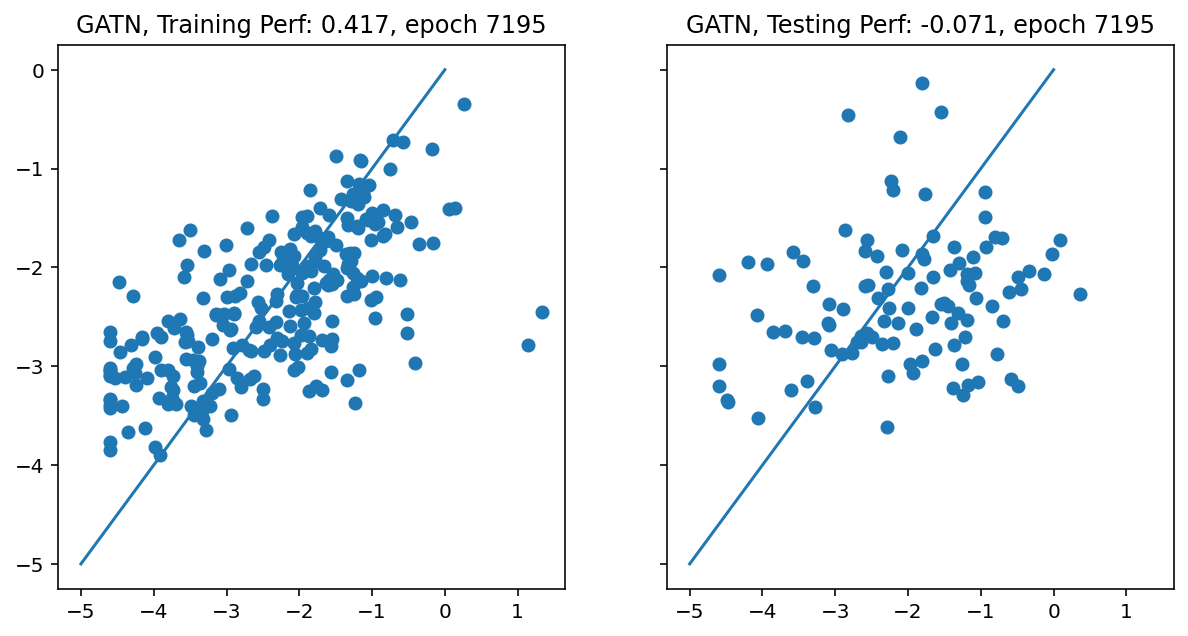

In [16]:
    fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
ax[0].scatter(train_target_lst[4267].squeeze(), pred_lst[4267].squeeze())
ax[0].plot([-5, 0], [-5, 0])
ax[0].set_title(f"GATN, Training Perf: {evs(train_target_lst[4267].squeeze(), pred_lst[4267].squeeze()):.3f}, epoch 7195")
ax[1].scatter(test_target_lst[4267].squeeze(), pred_test_lst[4267].squeeze())
ax[1].plot([-5, 0], [-5, 0])
ax[1].set_title(f"GATN, Testing Perf: {evs(test_target_lst[4267].squeeze(), pred_test_lst[4267].squeeze()):.3f}, epoch 7195")

In [18]:
test_target_lst[4267].squeeze()- pred_test_lst[4267].squeeze()

tensor([ 2.6335, -1.2429,  1.4193, -0.5816, -0.2503, -1.6729, -2.5144,  0.5988,
        -1.5129, -0.5003, -2.3741,  0.7839,  0.8272,  2.5411,  0.5502, -0.7628,
         0.5638,  0.1282,  1.8323,  1.6995,  2.0984, -1.4245, -1.5966,  0.2122,
        -1.0487, -0.2509,  0.8581,  1.1559,  0.9684,  2.7135, -0.7118,  1.2007,
         0.0936, -0.0955,  0.0240, -1.9777, -0.5360, -1.2035,  0.4136,  0.0953,
         1.8155, -1.1116,  1.2419,  0.0505,  0.4280, -0.7571,  0.4399,  2.0209,
         1.6145, -0.5446,  2.1161, -0.2375,  1.4802, -1.6129,  1.5381,  0.8723,
        -0.8399,  0.3864,  0.2945, -1.1169, -0.0266,  0.6566, -0.3752,  1.1445,
         1.3272,  1.7806,  0.9434,  1.1412,  2.0496,  0.1468,  0.8289,  1.0127,
        -0.2206,  0.1333,  0.8277, -0.4758,  1.0111,  1.1382, -0.5121, -1.7384,
         0.9319, -0.5432,  0.2111, -0.4069,  0.0492,  1.6371, -1.3956,  0.0448,
         1.9349,  1.3449,  0.8886,  0.1042,  1.8393,  0.8616,  0.9845,  1.8467,
         0.7369, -0.9845, -0.0610,  1.72

In [22]:
train_target_lst[4267].squeeze()- pred_train_lst[4267].squeeze()

NameError: name 'pred_train_lst' is not defined

In [21]:
test_target_lst[4267].tolist()[4], pred_test_lst[4267].tolist()[4]

(-2.301544666290283, [-2.0512068271636963])

In [28]:
# get index from the list whose value is close to the test target chosen
min(enumerate(targets[251:]), key=lambda x: abs(x[1]+2.3015446))

(35, -2.301544551818798)

In [29]:
# confirm it is the right target
targets[286]

-2.301544551818798

In [32]:
atten = atten_test_lst[4267]
atten.shape

torch.Size([3148, 1, 1])

In [75]:
num = 52

In [76]:
one_out_target, one_atten = net(test_dataset[num][0], 
                             test_dataset[num][0].ndata["feat"])

<AxesSubplot:>

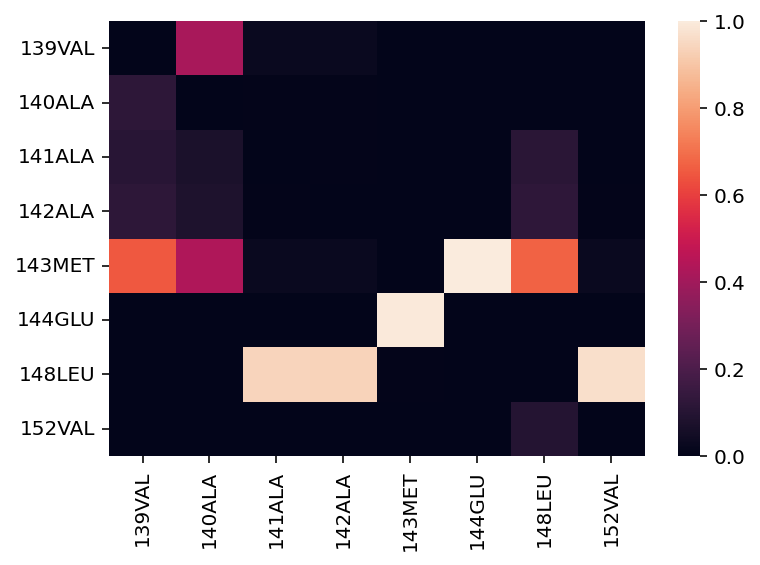

In [77]:
import seaborn as sns
#labels = list(sorted(all_networkx_graphs[357].nodes()))

labels = list(sorted(test_dataset[num][1].values()))
from numpy.random import default_rng
#https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
a =np.zeros((len(labels),len(labels)))#default_rng(42).random((len(labels),len(labels)))
for i in range(len(test_dataset[num][0].edges(form = "uv")[0])):
    a[test_dataset[num][0].edges(form = "uv")[0][i], test_dataset[num][0].edges(form = "uv")[1][i]] =  one_atten[i]

sns.heatmap(a,
                xticklabels = labels, 
                yticklabels= labels)

In [78]:
b = pd.DataFrame(a)
b

,0,1,2,3,4,5,6,7
0,0.000000,0.415456,0.025415,0.025333,0.000133,0.0,0.000000,0.000000
1,0.120656,0.000000,0.004907,0.004891,0.000026,0.0,0.000000,0.000000
2,0.107960,0.071766,0.000000,0.004376,0.000023,0.0,0.111154,0.000000
3,0.119420,0.079384,0.004856,0.000000,0.000025,0.0,0.122953,0.005008
4,0.651964,0.433393,0.026513,0.026426,0.000000,1.0,0.671255,0.027342
5,0.000000,0.000000,0.000000,0.000000,0.994882,0.0,0.000000,0.000000
6,0.000000,0.000000,0.938309,0.935249,0.004892,0.0,0.000000,0.967650
7,0.000000,0.000000,0.000000,0.003726,0.000019,0.0,0.094637,0.000000


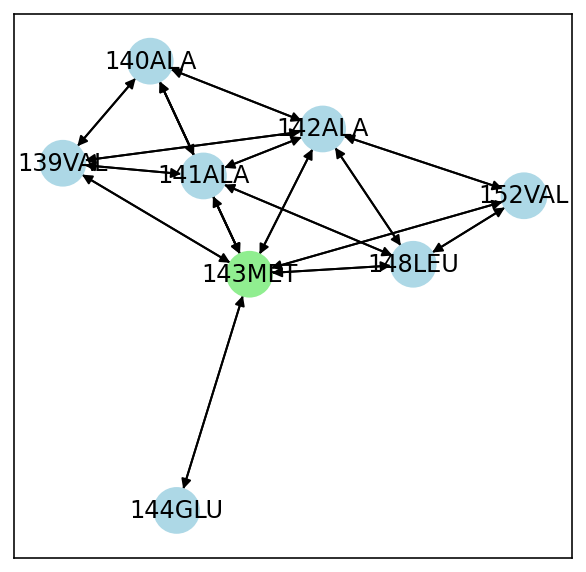

In [79]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))

dgl_to_nx = nx.relabel_nodes(test_dataset[num][0].to_networkx(), mapping = test_dataset[num][1])
#nx.draw_networkx(one_dgl_graph.to_networkx(), with_labels=True, node_size =500)
nx.draw_networkx(dgl_to_nx, with_labels=True, node_size =500,
                node_color = ['lightblue' if 'MET' not in i else 'lightgreen' for i in list(test_dataset[num][1].values())])

#nx.draw_networkx(test_dataset[35][0], with_labels=True, node_size =500,
#                node_color = ['lightblue' if 'MET' not in i else 'lightgreen' 
#                              for i in list(all_networkx_graphs[357].nodes())])

In [71]:
['lightblue' if 'MET' not in i else 'lightgreen' for i in list(test_dataset[num][1].values())]

['lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightblue',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue']

In [ ]:
dataset[4][0].ndata["feat"][:5,:5]

In [ ]:
dataset[4][2][:5,:5]

In [ ]:
import dgl
import numpy as np
import torch as th
from dgl.nn import GATConv
from dgl.nn import AvgPooling
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
g = dgl.add_self_loop(g)
g = dgl.batch([g,g])
feat = th.ones(12, 10) # (n_node, n_feat)
gatconv = GATConv(10, 2, num_heads=3)
res = gatconv(g, feat)
res = res.flatten(start_dim =1)
print(res.shape)
poolinglayer = AvgPooling() 
# graph attention use graph connectivity to perform pooling, if graphs are not connected, it will be viewed as seperated graph
res = poolinglayer(g, res)

res.shape #(#nodes, # heads, outdim is 2)


In [ ]:
g.batch_size, g.batch_num_nodes(), g.nodes()

In [ ]:
res.flatten(start_dim =1)

In [ ]:
g.in_degrees(),feat

In [ ]:

nx.draw_networkx(g.to_networkx(), with_labels=True,node_size =400)

In [ ]:
atten = atten.squeeze()

In [ ]:
all_graphs[2].edges(form = "uv")[0],all_graphs[2].edges(form = "uv")[1]

### draw attention plot

In [ ]:
import seaborn as sns
labels = list(sorted(all_networkx_graphs[2].nodes()))
labels
from numpy.random import default_rng
#https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
a =np.zeros((len(labels),len(labels)))#default_rng(42).random((len(labels),len(labels)))
for i in range(len(all_graphs[2].edges(form = "uv")[0])):
    a[all_graphs[2].edges(form = "uv")[0][i], all_graphs[2].edges(form = "uv")[1][i]] =  atten[i]

sns.heatmap(a,
                xticklabels = labels, 
                yticklabels= labels)

In [ ]:
b = pd.DataFrame(a)
b

In [ ]:
#dgl_to_nx = nx.relabel_nodes(all_graphs[2].to_networkx())
#nx.draw_networkx(one_dgl_graph.to_networkx(), with_labels=True, node_size =500)
nx.draw_networkx(all_graphs[2].to_networkx(), with_labels=True, node_size =500)

In [ ]:
import matplotlib.pyplot as plt

#nx.draw(all_graphs[0].to_networkx(), atten.squeeze())
G=nx.Graph()
i=1
G.add_node(i,pos=(i,i))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))
G.add_edge(1,2,weight=0.5)
G.add_edge(1,3,weight=9.8)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#nx.draw_networkx(all_graphs[0].to_networkx())

In [ ]:
labels

In [ ]:
atten.tolist()

In [ ]:
dataset[1], pd.DataFrame(all_graph_features[1])

In [ ]:
all_graphs, all_feature = get_graph_and_feat_df(graphs, processed_data)

In [ ]:
len(all_graphs), all_feature[0].shape

In [ ]:
new_entry_list = processed_data["accession-sequence"].reset_index()
#new_entry_list
list(graphs[new_entry_list.loc[0,"accession-sequence"]].nodes())
# the keys in the dict of dgl will be indices

In [ ]:
graphs[new_entry_list.loc[0,"accession-sequence"]].edges()

In [ ]:
pd.DataFrame(all_feature[0]).iloc[:9,:]

In [ ]:
graphs[new_entry_list.loc[1,"accession-sequence"]].nodes()

In [ ]:
pd.DataFrame(all_feature[1]).iloc[[1,3,4],:]

In [ ]:
processed_data["accession-sequence"]

In [ ]:
all_graphs, all_feature = get_graph_and_feat_df(graphs, processed_data)
target = processed_data['ox_fwd_logit'].values

In [ ]:
type(target)

In [ ]:
type(all_feature)

In [ ]:
pd.DataFrame(all_feature[0])

In [ ]:
len(all_graphs), all_feature.shape, taget.shape

In [ ]:
all_graphs[0]

In [ ]:
import dgl

In [ ]:
dgl_graphs = [dgl.from_networkx(graph) for graph in all_graphs]

In [ ]:
dgl_graphs[0]

In [ ]:
dgl.__version__

In [ ]:
# taken from https://github.com/dmlc/dgl/issues/1887
from dgl.nn.pytorch.conv import GATConv
import torch.nn as nn
import torch.nn.functional as F
import torch

class GATDefault(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATDefault, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1)

    def forward(self, g, h):
        h = self.layer1(g, h)
        # Concat last 2 dim (num_heads * out_dim)
        h = h.view(-1, h.size(1) * h.size(2)) # (in_feat, num_heads, out_dim) -> (in_feat, num_heads * out_dim)
        h = F.elu(h)
        h = self.layer2(g, h)
        # Sueeze the head dim as it's = 1 
        h = h.squeeze() # (in_feat, 1, out_dim) -> (in_feat, out_dim)
        return h



In [ ]:
net = GATDefault(
          in_dim=67 ,#features.size(1),
          hidden_dim=128,
          out_dim=64,
          num_heads=1)
print(net)

In [ ]:
#dgl no need to pad 
g = dgl_graphs[0]
features = np.squeeze(all_feature[0])
features = torch.tensor(features[:9,:], dtype =torch.float32)
features.shape
g, features.shape

In [ ]:
len(g.nodes())
#pd.DataFrame(features.numpy())
features = np.squeeze(all_feature[0])
type(features)

In [ ]:
# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    out_from_attention = net(g, features)
    logp = F.linear(out_from_attention, 1)#F.log_softmax(logits, 1) # probably need to change to linear regression
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

In [ ]:
out = net(g, features)
out.shape

In [ ]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, mask
g_exam, features_exam, labels_exam, mask_exam = load_cora_data()


In [ ]:
g_exam,features_exam.shape

In [ ]:
features_exam.shape

In [ ]:
# how to make my dataset: https://docs.dgl.ai/tutorials/blitz/6_load_data.html#sphx-glr-tutorials-blitz-6-load-data-py
#https://bitbucket.prd.nibr.novartis.net/projects/CHEMGNN/repos/chemgnn/browse

In [ ]:
import dgl
from dgl.data import DGLDataset
import torch
import os
from typing import List, Optional
import networkx as nx
from tqdm import tqdm
from patch_gnn.dgl_dataset import get_graph_and_feat_df

def convert_networkx_to_dgl(one_networkx_graph:nx.Graph, one_graph_feature:np.ndarray):
    """
    Convert one networkx graph to dgl graph
    :param one_networkx_graph: one nx.Graph
    :param one_graph_feature: ndarray of shape (n_node, m_features), n_node could vary in length
                              n_node match to the correpsonding num of nodes in one_networkx_graph
    """
    dgl_graph = dgl.from_networkx(one_networkx_graph)
    dgl_graph.ndata['feat'] = torch.from_numpy(one_graph_feature)
    return dgl_graph
    

class PatchGNNDataset(DGLDataset):
    def __init__(self,
                 name: str = 'ghesquire_2011',
                 networkx_graphs: List[nx.Graph] = None,
                 labels: np.ndarray = None,
                 features: List[np.ndarray] = None,
                 networkx_to_dglgraph: callable = convert_networkx_to_dgl):
        """
        init this class
        :params networkx_graph: a list of graphs in networkx format
        :params labels: the target of prediction
        :features: a list, each element is a feature matrix of the corresponding graph from networkx_graph, 
                    should be of shape (n_node, m_features) with no padding. n_node varies for each graph,
                    m_features is fixed for all graphs.         
        """
        self.networkx_graphs = networkx_graphs
        self.features = features
        self.labels = torch.from_numpy(labels)
        self.nodenames = [list(graph.nodes()) for graph in networkx_graphs]
        super().__init__(name= name)

    def process(self):
        # convert networkx_graphs to dgl graphs
        dgl_graphs = []
        for idx in tqdm(range(len(self.networkx_graphs))):
            dgl_graphs.append(convert_networkx_to_dgl(self.networkx_graphs[idx], self.features[idx]))
            
        self.dgl_graphs = dgl_graphs

    def __getitem__(self, idx):
        return self.dgl_graphs[idx], self.labels[idx], self.nodenames[idx]

    def __len__(self):
        return len(self.dgl_graphs)

all_graphs, all_feature = get_graph_and_feat_df(graphs, processed_data)
target = processed_data['ox_fwd_logit'].values
dataset = PatchGNNDataset(
                 networkx_graphs= all_graphs,
                 labels = target,
                 features= all_feature)


In [ ]:
#all_feature[1].shape
dgl_graph = dgl.from_networkx(all_graphs[0])
dgl_graph.ndata['feat'] = torch.from_numpy(all_feature[0])
dgl_graph

In [ ]:
all_feature[1].shape

In [ ]:
#torch.FloatTensor
#(list(graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()))
graphs['Q9H0U4-MGPGAASGGERPNLK']

In [ ]:
dgl.from_networkx(graphs['Q9H0U4-MGPGAASGGERPNLK'], node_attrs =list(graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()) )

In [ ]:
graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()

In [ ]:
torch.from_numpy(list(graphs['Q9H0U4-MGPGAASGGERPNLK'].nodes()).astype('category').cat.codes.to_numpy())

In [ ]:
import networkx as nx
import dgl

#g_nx = nx.petersen_graph()
#g_dgl = dgl.DGLGraph(g_nx)
g_dgl = dgl.from_networkx(graphs['Q9H0U4-MGPGAASGGERPNLK'])
import matplotlib.pyplot as plt
#plt.subplot(121)
#nx.draw(g_nx, with_labels=True)
#plt.subplot(122)
plt.subplot(111)
nx.draw(g_dgl.to_networkx(), with_labels=True)